**Gold Price Prediction using Machine Learning**

In this project we will try to build a model about analyzing the gold price prediction.

**Problem Formulation**

The price of gold is volatile, they change rapidly with time. Our main goal of this project will be to predict the price of gold per unit.

**📊 Dataset Definition (Macro Financial Indicators) :**

This dataset provides daily historical financial and economic indicators for selected assets and exchange rates. Each row represents data for a specific date.

**Date :** The calendar date of the observation in MM/DD/YYYY format.

**SPX	:** S&P 500 Index closing value, representing large-cap U.S. equity market performance.

**GLD	:** SPDR Gold Shares (GLD) ETF price, serving as a proxy for gold market performance.

**USO	:** United States Oil Fund (USO) ETF price, serving as a proxy for crude oil performance.

**SLV :** iShares Silver Trust (SLV) ETF price, representing silver market performance.

**EUR/USD	:** Euro to U.S. Dollar foreign exchange rate on the given date. Represents how many USD one Euro buys.

**Source Note:**

Asset values appear to be daily closing prices for major ETFs and currency rates. Confirm with the origin of the data feed or provider before analysis.

**Importing Libraries**

We will import all the libraries that we will be using throughout this article in one place so that do not have to import every time we use it this will save both our time and effort.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid", {"grid.color": ".6",
                           "grid.linestyle": ":"})

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

**Loading the Dataset**


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/gold_price_data.csv', index_col=0, parse_dates=['Date'])
df.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,2008-01-02,1447.160034,84.860001,78.470001,15.180,1.471692
1,2008-01-03,1447.160034,85.570000,78.370003,15.285,1.474491
2,2008-01-04,1411.630005,85.129997,77.309998,15.167,1.475492
3,2008-01-07,1416.180054,84.769997,75.500000,15.053,1.468299
4,2008-01-08,1390.189941,86.779999,76.059998,15.590,1.557099


In [ ]:
df.Date.max(), df.Date.min() #between 01-2008 and 05-2018

(Timestamp('2018-05-16 00:00:00'), Timestamp('2008-01-02 00:00:00'))

In [ ]:
#information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     2290 non-null   datetime64[ns]
 1   SPX      2290 non-null   float64       
 2   GLD      2290 non-null   float64       
 3   USO      2290 non-null   float64       
 4   SLV      2290 non-null   float64       
 5   EUR/USD  2290 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 125.2 KB


In [ ]:
df.shape

(2290, 6)

**Data preprocessing**

Now let's check the missing values of our dataset.

In [ ]:
df.isna().sum().sort_values(ascending=False) #we do not have any missing values.

Date       0
SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype: int64

**Checking Correlations**

For Multicollinearity Check

We should always check if there is any correlation between the two columns of our dataset. If two or more columns are correlated with each other and none of them is a target variable then we must use a method to remove this correlation. Some of the popular methods are PCA(principal component Analysis). We can also remove one of two columns or make a new one using these two.

In our dataset we need to check if there is any correlation between the two columns. We can also remove one of two columns or make a new one using these two columns that is called feature engineering.

In [ ]:
df.columns

Index(['Date', 'SPX', 'GLD', 'USO', 'SLV', 'EUR/USD'], dtype='object')

In [ ]:
df.dtypes

Date       datetime64[ns]
SPX               float64
GLD               float64
USO               float64
SLV               float64
EUR/USD           float64
dtype: object

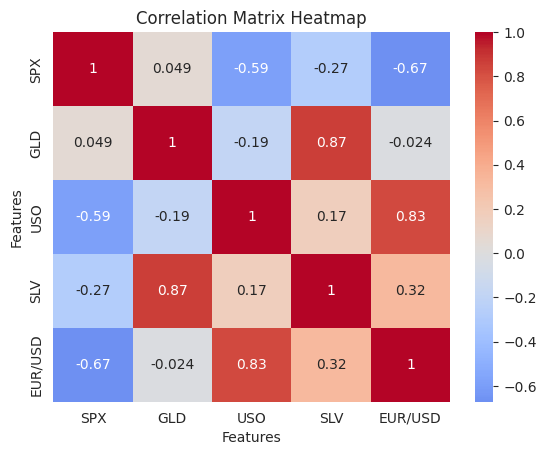

In [ ]:
#calculate correlation matrix
correlation=df.corr()

#create a heatmap
sns.heatmap(correlation, cmap='coolwarm', center=0, annot=True)

#set title and axis labels
plt.title('Correlation Matrix Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')

#show plot
plt.show()

According to our heatmap we can see that the two columns SLV and GLD are strongly correlated with each other compared to others, so in here we need to take this into account which features have large correlation with our target column (y = df['EUR/USD'])

**Data Wrangling**

In this step we will try to gain insight and knowledge from the data. We see data through every aspect and try to fetch most of the information from the dataframe.

In [ ]:
#resetting the index of our dataframe and creating a new index
df.set_index('Date', inplace=True)
df.head()

,SPX,GLD,USO,SLV,EUR/USD
Date,,,,,
2008-01-02,1447.160034,84.860001,78.470001,15.180,1.471692
2008-01-03,1447.160034,85.570000,78.370003,15.285,1.474491
2008-01-04,1411.630005,85.129997,77.309998,15.167,1.475492
2008-01-07,1416.180054,84.769997,75.500000,15.053,1.468299
2008-01-08,1390.189941,86.779999,76.059998,15.590,1.557099


Let's now check the change in gold price during the whole year.

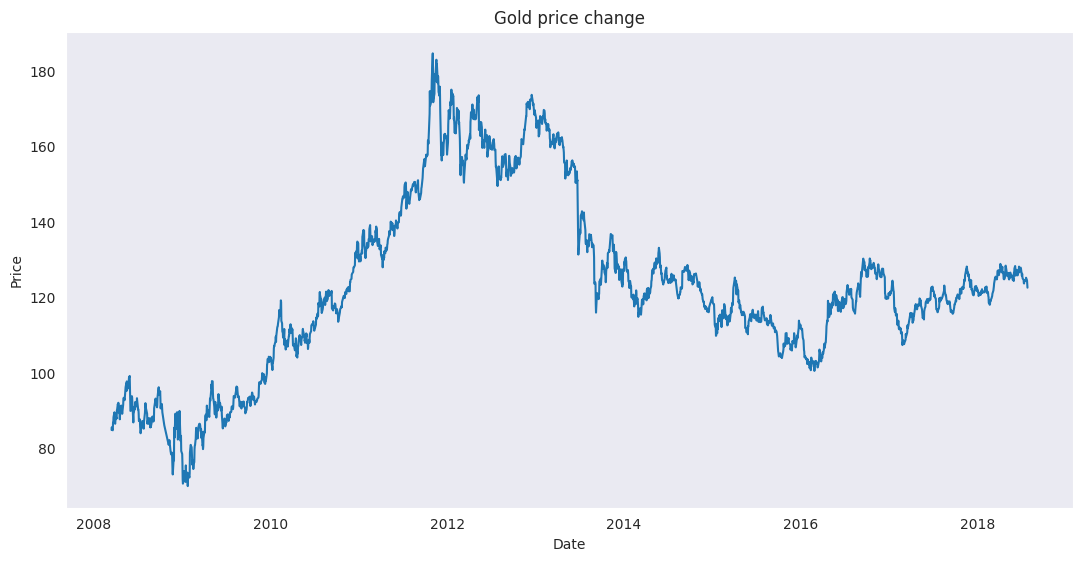

In [ ]:
#plot price of gold for each increasing day
df["GLD"].plot(figsize=(13,7)) #df["GLD"] or df['EUR/USD']
plt.title("Gold price change")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=0)
plt.grid(False)
plt.show()

According to this graph we see downwards and upwards trends in each year period but may not see a good insight of the change in the price of gold that is why we need to make the graph more observable.

**Changing Time Period**

To visualize the trend in the data we have to apply a moving average process with 20 previous data points on this line.



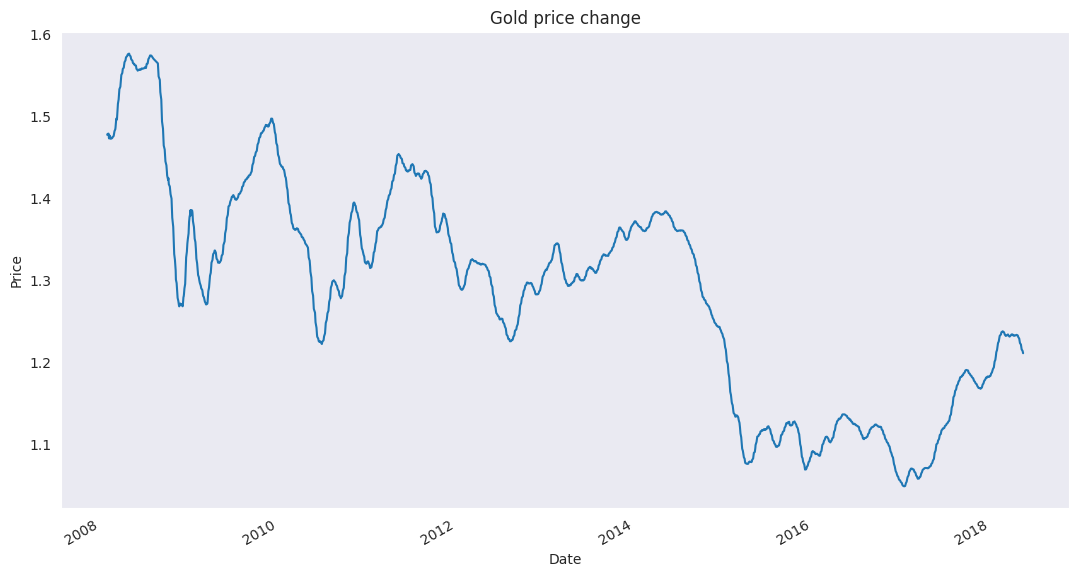

In [ ]:
#rolling mean with 20 windows
df['price_trend']=df['GLD'].rolling(window=20).mean()

#reseting the index
#df.reset_index('Date', inplace=True)

#since we have used rolling method
#for 20 rows first 2 rows will be NAN
#dataset["price_trend"].loc[20:].plot()

df["price_trend"].plot(figsize=(13,7))

#set title of the chart
plt.title("Gold price change")

#set x_label of the plot
plt.grid(False)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [ ]:
df.head(20) #check the price_trend NaN values in here before plotting.

,SPX,GLD,USO,SLV,EUR/USD,price_trend
Date,,,,,,
2008-01-02,1447.160034,84.860001,78.470001,15.180000,1.471692,NaN
2008-01-03,1447.160034,85.570000,78.370003,15.285000,1.474491,NaN
2008-01-04,1411.630005,85.129997,77.309998,15.167000,1.475492,NaN
2008-01-07,1416.180054,84.769997,75.500000,15.053000,1.468299,NaN
2008-01-08,1390.189941,86.779999,76.059998,15.590000,1.557099,NaN
2008-01-09,1409.130005,86.550003,75.250000,15.520000,1.466405,NaN
2008-01-10,1420.329956,88.250000,74.019997,16.061001,1.480100,NaN
2008-01-11,1401.020020,88.580002,73.089996,16.077000,1.479006,NaN
2008-01-14,1416.250000,89.540001,74.250000,16.280001,1.486900,NaN


Now the graph looks better and we can analyze the trend of the gold price. Let's drop price_trend column in here.

In [ ]:
df.drop('price_trend', axis=1, inplace=True)

In [ ]:
df.head()

,SPX,GLD,USO,SLV,EUR/USD
Date,,,,,
2008-01-02,1447.160034,84.860001,78.470001,15.180,1.471692
2008-01-03,1447.160034,85.570000,78.370003,15.285,1.474491
2008-01-04,1411.630005,85.129997,77.309998,15.167,1.475492
2008-01-07,1416.180054,84.769997,75.500000,15.053,1.468299
2008-01-08,1390.189941,86.779999,76.059998,15.590,1.557099


In [ ]:
#checking missing values again
df.isna().sum()

SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype: int64

**Distribution of Columns**

Now we will try to see the distribution of our other numerical columns.

In [ ]:
df.reset_index(inplace=True)
df.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,2008-01-02,1447.160034,84.860001,78.470001,15.180,1.471692
1,2008-01-03,1447.160034,85.570000,78.370003,15.285,1.474491
2,2008-01-04,1411.630005,85.129997,77.309998,15.167,1.475492
3,2008-01-07,1416.180054,84.769997,75.500000,15.053,1.468299
4,2008-01-08,1390.189941,86.779999,76.059998,15.590,1.557099


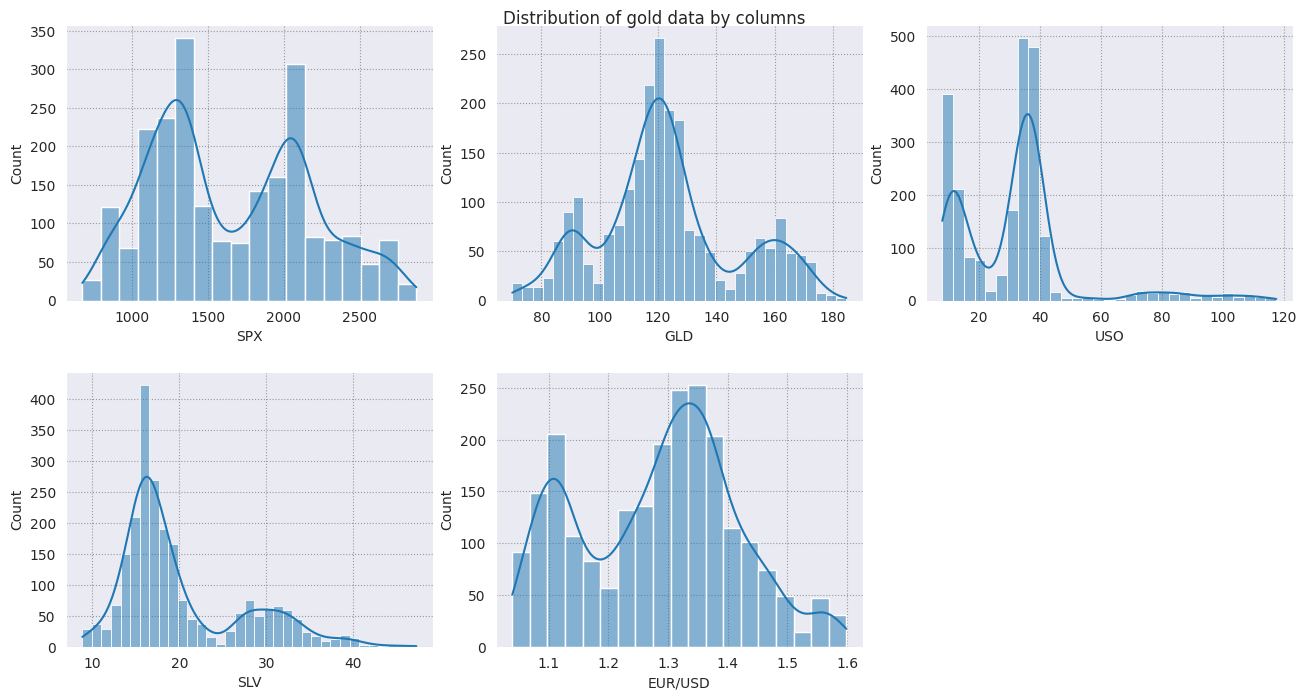

In [ ]:
fig=plt.figure(figsize=(13,7))
fig.suptitle('Distribution of gold data by columns')
fig_columns=df.drop('Date', axis=1).columns.tolist()
for column_index, column_name in enumerate(fig_columns):
  plt.subplot(2,3,column_index+1)
  sns.histplot(data=df, x=column_name, kde=True)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

According to our histograms the data looks good but we need to check the skewness of each column now.

In [ ]:
df.head(20)

,Date,SPX,GLD,USO,SLV,EUR/USD
0,2008-01-02,1447.160034,84.860001,78.470001,15.180000,1.471692
1,2008-01-03,1447.160034,85.570000,78.370003,15.285000,1.474491
2,2008-01-04,1411.630005,85.129997,77.309998,15.167000,1.475492
3,2008-01-07,1416.180054,84.769997,75.500000,15.053000,1.468299
4,2008-01-08,1390.189941,86.779999,76.059998,15.590000,1.557099
5,2008-01-09,1409.130005,86.550003,75.250000,15.520000,1.466405
6,2008-01-10,1420.329956,88.250000,74.019997,16.061001,1.480100
7,2008-01-11,1401.020020,88.580002,73.089996,16.077000,1.479006
8,2008-01-14,1416.250000,89.540001,74.250000,16.280001,1.486900
9,2008-01-15,1380.949951,87.989998,72.779999,15.834000,1.480210


In [ ]:
#skewness along the index axis
df.skew(axis=0, skipna=True).sort_values(ascending=False)

USO        1.699331
SLV        1.153641
GLD        0.334138
SPX        0.300362
EUR/USD   -0.005292
dtype: float64

In here we can see that USO and SLV columns have high skewness of 1.699 and 1.153 and we will apply some methods to reduce its skewness.



In [ ]:
df[['USO', 'SLV']]

,USO,SLV
0,78.470001,15.1800
1,78.370003,15.2850
2,77.309998,15.1670
3,75.500000,15.0530
4,76.059998,15.5900
...,...,...
2285,14.060000,15.5100
2286,14.370000,15.5300
2287,14.410000,15.7400
2288,14.380000,15.5600


In [ ]:
#applying square root transformation
df[['USO', 'SLV']]=df[['USO', 'SLV']].apply(lambda x:np.sqrt(x))

**Handling Outliers**

Outliers may add large mean square error that is why removing outliers is a good process in EDA.

Some models like Decisiontree and ensemble methods like RandomForests are not that much by outliers. However, it is always a good practice to handle the outlier.


In [ ]:
df.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,2008-01-02,1447.160034,84.860001,8.858329,3.896152,1.471692
1,2008-01-03,1447.160034,85.570000,8.852683,3.909604,1.474491
2,2008-01-04,1411.630005,85.129997,8.792610,3.894483,1.475492
3,2008-01-07,1416.180054,84.769997,8.689074,3.879820,1.468299
4,2008-01-08,1390.189941,86.779999,8.721238,3.948417,1.557099


**Plotting Boxplot to Visualize the Outliers**

Let's see the distribution of our data with boxplots and check the outliers in our dataset.



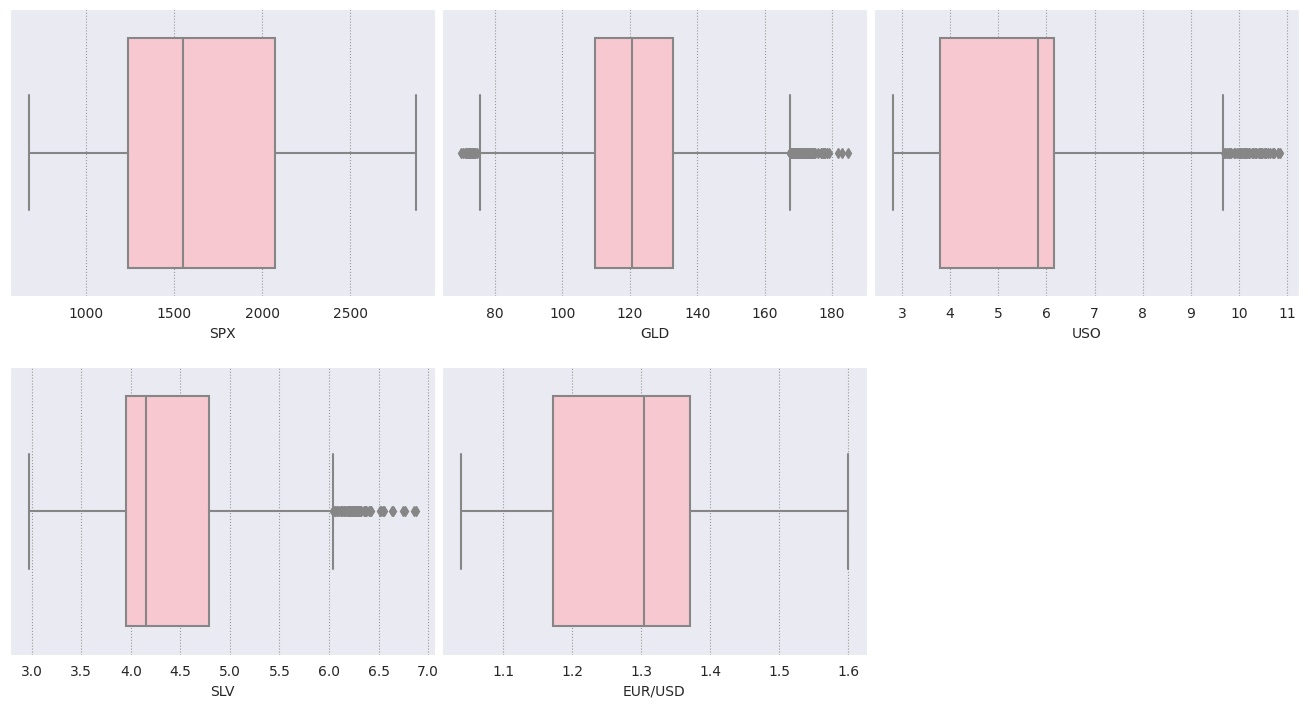

In [ ]:
fig=plt.figure(figsize=(13,7))
fig_columns=df.drop('Date', axis=1).columns.tolist()
for column_index, column_name in enumerate(fig_columns):
  plt.subplot(2,3,column_index+1)
  sns.boxplot(data=df, x=column_name, color='pink')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

According to our graph we can see some outliers. Let's remove them.

In [ ]:
def outlier_removal(df_column):
  upper_limit=df_column.quantile(0.95)
  lower_limit=df_column.quantile(0.05)
  df_column.loc[(df_column>upper_limit)]=upper_limit
  df_column.loc[(df_column<lower_limit)]=lower_limit
  return df_column

In here we have set the upper limit of the column to 95 %of the data and the lower limit to the 5 %. that means that which are greater than 95% percentile of the data are normalized to the data 95% value same for the data points which are lower than 5% of the data.

Let's normalize the columns except Date column :

In [ ]:
df[['SPX', 'GLD', 'USO', 'EUR/USD']]=df[['SPX', 'GLD', 'USO', 'EUR/USD']].apply(outlier_removal)

Now let's look at out final dataset before modeling :

In [1]:
df.head() #Our final dataset before modeling

NameError: name 'df' is not defined

**Modeling the Data**

In [ ]:
#select the features and target variable
X = df.drop(['Date', 'EUR/USD'], axis=1)
y = df['EUR/USD']

In [ ]:
#dividing dataset in to train test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**Scaling the Data**

Before we train the model on our data we should perform scaling on our data to normalize. (z-score normalization)

It brings all the columns to the same scale and directly comparable with one another.



In [ ]:
#create an instance of the StandardScaler
scaler = StandardScaler()

#fit the StandardScaler on the training dataset
scaler.fit(x_train)

#transform the training dataset using the StandardScaler
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

**Using Lasso Regression**

In this model, we have used linear regression with L1 Regularization, also with help of the make_pipeline object, we will use lasso regression with 2 degrees. We will also use the GridSearch object to get the best-performing hyperparameter and lower the variance.

In [ ]:
#create a PolynomialFeatures object of degree 2
poly = PolynomialFeatures(degree=2)

#create a Lasso object
lasso = Lasso()

#define a dictionary of parameter values to search over
param_grid = {'lasso__alpha': [1e-4, 1e-3, 1e-2,
                               1e-1, 1, 5, 10,
                               20, 30, 40]}
#creating our pipeline
pipeline=make_pipeline(poly, lasso)

#create a GridSearchCV object
lasso_grid_search = GridSearchCV(pipeline,
                                 param_grid,
                                 scoring='r2', cv=3)

#fitting the GridSearchCV object to the training data
lasso_grid_search.fit(x_train_scaled, y_train)

#predicting the target variable using the fitted model and the test data
y_pred = lasso_grid_search.predict(x_train_scaled)

#compute the R-squared of the fitted model on the train data
r2 = r2_score(y_train, y_pred)

#print the R-squared score
print("R-squared: ", r2)

#print the best parameter values and score
print('Best parameter values: ', lasso_grid_search.best_params_)
print('Best score: ', lasso_grid_search.best_score_)

R-squared:  0.8918605736028874
Best parameter values:  {'lasso__alpha': 0.0001}
Best score:  0.8894160462495088


Here we are fitting our multiple regression of degree, however, to use lasso regression with multiple regression we must use the pipeline method from sklearn. We will also use the grid search method for cross-validation and selecting the best-performing hyperparameter for the training data. Grid search is one of the best ways to find a model which does not overfit the training data.

We have used the R-squared evaluation matrix throughout our model. We have used this matrix since we want to compare our model and choose which is best performing.

**RandomForestRegressor for Regression**

In the second model, we will use the ensemble method to fit our training data. like in Random Forest it uses several decision trees to fit on the data, one thing to note is that in random forest regressor m number of rows are used for training which is always less than n (m<n). where n is the total number of original columns present in the training dataset, also for row points random forest select these row’s element.

In [ ]:
#instantiate param grid for which to search
param_grid = {'n_estimators': [50, 80, 100],
			        'max_depth': [3, 5, 7]}

#create instance of the Randomforest regressor
rf = RandomForestRegressor()

#define Girdsearch with random forest
# object parameter grid scoring and cv
rf_grid_search = GridSearchCV(rf, param_grid, scoring='r2', cv=2)

#fit the GridSearchCV object to the training data
rf_grid_search.fit(x_train_scaled, y_train)

#print the best parameter values and score
print('Best parameter values: ', rf_grid_search.best_params_)
print('Best score: ', rf_grid_search.best_score_)

Best parameter values:  {'max_depth': 7, 'n_estimators': 80}
Best score:  0.9505731296117668


In here we have used both RandomForest regressor and Gridsearchcv, The Gridsearchcv will help in selecting the best number of decision trees from 50,80,100. We have also specified the maximum depth of the tree as a parameter which can be 3,5 or 7.

The best parameter value shows that the model gives the best result when it takes the average result of one hundred decision trees having a maximum depth of 7.

In [ ]:
#compute the R-squared of the fitted model on the test data
r2 = r2_score(y_test, rf_grid_search.predict(x_test_scaled))

#print the R-squared
print("R-squared:", r2)

R-squared: 0.950411905796411


These models are called "Black Box Models" since we won’t be able to visualize what is happening under the hood of the model however, we will plot the bar chart of the feature importance from the dataset.

In [ ]:
#our features
features = df.drop(['Date', 'EUR/USD'], axis=1).columns #we dropped the SLV before !!!! ???
features

Index(['SPX', 'GLD', 'USO', 'SLV'], dtype='object')

In [ ]:
#store the importance of the feature
importances = rf_grid_search.best_estimator_.feature_importances_ #rf is random forest grid search in here.
importances

array([0.05697291, 0.0245516 , 0.87354101, 0.04493448])

In [ ]:
indices = np.argsort(importances)
indices

array([1, 3, 0, 2])

In [ ]:
importances[indices]

array([0.0245516 , 0.04493448, 0.05697291, 0.87354101])

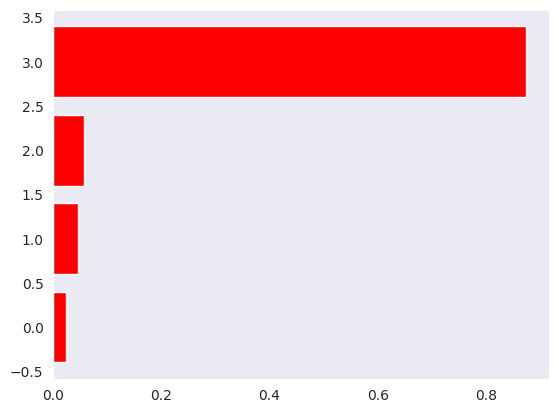

In [ ]:
#plotting our indices
plt.barh(range(len(indices)),
		importances[indices],
		color='red',
		align='center')
plt.grid(False)
plt.show()

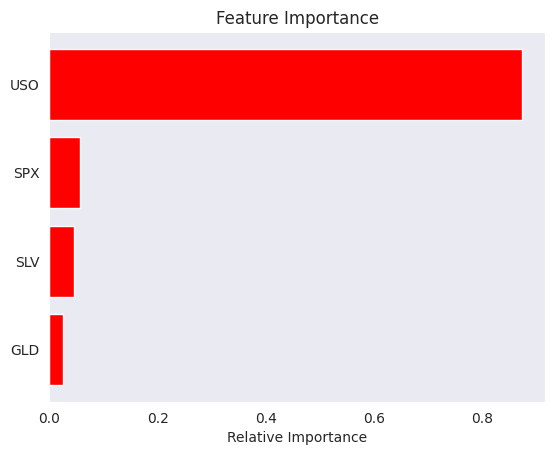

In [ ]:
#plotting our complete bar chart
plt.title('Feature Importance')
plt.barh(range(len(indices)),
		importances[indices],
		color='red',
		align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid(False)
plt.show()

This feature importance graph shows that USO column plays a major effect (more than 2x) in deciding the gold price in USD.

**XGBoost Model for Regression**

In boosting technique the data is fitted in several sequential weak learning algorithm models which are only slightly better than random guessing. In each next sequential model more weights are given to the points which are misclassified/regressed by previous models.

In our models, we will use the XGBOOST model for fitting our training dataset.



In [ ]:
#create an instance of the XGBRegressor model
model_xgb = XGBRegressor()

#fit the model to the training data
model_xgb.fit(x_train_scaled, y_train)

#print the R-squared score on the training data
print("Xgboost Accuracy =", r2_score(y_train, model_xgb.predict(x_train_scaled)))

Xgboost Accuracy = 0.9989065784957798


Now let’s evaluate this model with our testing data.

In [ ]:
#print the R-squared score on the test data
print("Xgboost Accuracy on test data =", r2_score(y_test, model_xgb.predict(x_test_scaled)))

Xgboost Accuracy on test data = 0.9744671810747202


Through the graph, we can see that USO column plays a major role in deciding the prediction value. We need to fix this ? Where is the graph ?

**Model Explainability**

In the black box model Boosting and Bagging, we will not be able to see the actual weights given to these columns however there are some libraries that we can use to the fraction of weight out of 1 given to a particular column when we predict on a single vector. We will be using eli5 package to demonstrate the model explainability. You can install this package by running the following command in the terminal.

In [ ]:
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107717 sha256=5220c0b11d58bb6670d633f43e5c83965631dc2d0c33e5a4ada403f20c7aa315
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


The name eli5 stands for “Explain like I’m 5” it’s a popular Python library that is used for debugging and explaining machine learning models.

We will use eli5 to see the Weights of our best-performing model which is  XGBOOST in here as we can see best on its train and test accuracy.

In [ ]:
import eli5 as eli
#weight of variables in xgboost model
#get the names of the features
feature_names = x_train.columns.tolist()
feature_names

['SPX', 'GLD', 'USO', 'SLV']

In [ ]:
# Explain the weights of the features using ELI5
eli.explain_weights(model_xgb, feature_names=feature_names)

Weight,Feature
0.8474,USO
0.0577,SLV
0.0557,SPX
0.0392,GLD


According to our output, we can see that USO column plays an important role in deciding the prediction value.

**Model Deployment using Pickle**

To deploy the model we will use the pickle library from the Python language.

We will deploy our best-performing model which is XGBoost. Pickle is a Python module that is used for serializing and deserializing the model i.e saving and loading the model. It stores Python objects which can be moved to a disk(serializing) and then again from disk to memory(deserialize).

In [ ]:
model_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
#dump model using pickle library
import pickle

#dump model in file model.pkl
gold_pred_model_xgb=model_xgb
pickle.dump(gold_pred_model_xgb, open('gold_pred_model_xgb.pkl', 'wb'))

Now we can use the load function from pickle to load the gold_pred_model_xgb into memory to predict a new vector dataset.

**Conclusions**

We have made our data science project from scratch to deployment after saving the file into a disk using pickle.dump which stores it into byte data files.

We can again load our model gold_pred_model_xgb.pkl file using pickle. We can take the help of flask or another framework to run and use our model to predict live coming datasets.